In [248]:
import pandas as pd
import numpy as np
from trails.optimizer import trans_emiss_calc, post_prob_wrapper
from trails.read_data import maf_parser
from trails.cutpoints import cutpoints_ABC
%load_ext rpy2.ipython

n_int_AB_original = 3
n_int_ABC_original = 3

n_int_AB = 10
n_int_ABC = 10

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [249]:
df = pd.read_csv('chr21_L-BFGS-B.csv')
df = df[df['loglik'] == df['loglik'].max()]
dct = dict(zip(list(df.columns), df.iloc[0].to_list()))

In [250]:
dct

{'n_eval': 296.0,
 't_A': 0.0033401224406377,
 't_B': 0.0035824845097278,
 't_C': 0.0062805113432487,
 't_2': 0.0023889437722545,
 't_upper': 0.0180277542266378,
 't_out': 0.0100957399885109,
 'N_AB': 0.0055229657239598,
 'N_ABC': 0.003953618877348,
 'r': 0.5103483216469739,
 'loglik': -52516466.2216394,
 'time': 96822.11412930489}

In [251]:
(2/3)*np.exp(-(dct["t_2"])/(dct["N_AB"]))

0.43256945200780456

In [252]:
cut_ABC_original = (cutpoints_ABC(n_int_ABC_original, 1)*dct["N_ABC"])[-2]

In [253]:
t_ABC = cut_ABC_original+dct["t_upper"]
t_ABC

0.022371248510002526

In [254]:
cut_ABC = (cutpoints_ABC(n_int_ABC, 2)*dct["N_ABC"])[-2]
t_upper = t_ABC-cut_ABC
t_upper

0.017819476564821846

In [255]:
new_cut_ABC = cutpoints_ABC(n_int_ABC, 2)

In [256]:
orig_cut_ABC_r = cutpoints_ABC(n_int_ABC, 1)*dct["N_ABC"]
new_cut_ABC_r = new_cut_ABC*dct["N_ABC"]
cut_exp_3 = cutpoints_ABC(n_int_ABC, 3)*dct["N_ABC"]
N_ref = dct["N_ABC"]

In [257]:
%%R -i n_int_ABC -i N_ref

library(PhaseTypeR)
library(ggthemes)

mat <- matrix(c(-3, 3, 0, -1), ncol = 2, byrow = TRUE)
ph <- PH(mat)
phase_type <- qPH((0:n_int_ABC)/n_int_ABC, ph)*N_ref
phase_type <- c(phase_type[0:(length(phase_type)-1)], Inf)

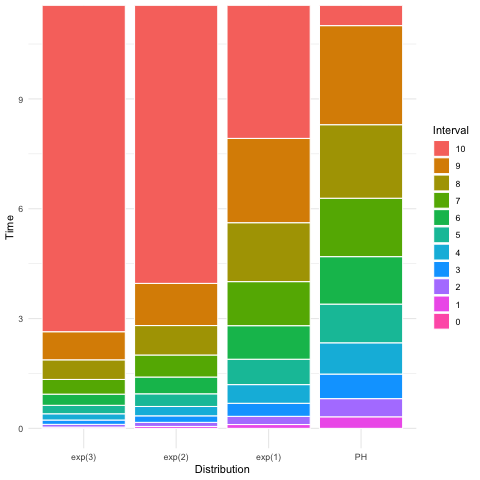

In [258]:
%%R -i orig_cut_ABC_r -i new_cut_ABC_r -i cut_exp_3

library(tidyverse)

tibble(
    `exp(1)` = orig_cut_ABC_r,
    `exp(2)` = new_cut_ABC_r,
    `PH` = phase_type,
    `exp(3)` = cut_exp_3
) %>%
    mutate(Interval = factor((1:n())-1, (n():1)-1)) %>%
    # filter(row_number() <= n()-1) %>%
    pivot_longer(-Interval) %>% 
    mutate(name = factor(name, c('exp(3)', 'exp(2)', 'exp(1)', 'PH'))) %>%
    ggplot() +
    geom_col(aes(name, value/N_ref, fill = Interval), color = 'white') +
    theme_minimal() +
    labs(x = 'Distribution', y = 'Time')

In [259]:
a, b, pi, hidden_names, observed_names = trans_emiss_calc(
    dct["t_A"], dct["t_B"], dct["t_C"], dct["t_2"], t_upper, dct["t_out"], 
    dct["N_AB"], dct["N_ABC"], dct["r"], n_int_AB, n_int_ABC,
    cut_AB = 'standard', cut_ABC = new_cut_ABC
)

/Users/au595587/opt/miniconda3/envs/phasetype/lib/python3.8/site-packages/trails/get_joint_prob_mat.py:151: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if cut_ABC == 'standard':
(PoolActor pid=40977) E0417 13:47:12.870843000 123145362984960 chttp2_transport.cc:1103]     Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"
(PoolActor pid=40975) E0417 13:47:12.869141000 123145610612736 chttp2_transport.cc:1103]     Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"
(PoolActor pid=40974) E0417 13:47:12.870368000 123145465225216 chttp2_transport.cc:1103]     Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"
/Users/au595587/opt/miniconda3/envs/phasetype/lib/python3.8/site-packages/trails/get_emission_prob_mat.py:632: FutureWarning: elementwise comparison failed; returning scalar instea

In [260]:
if 'obs' not in globals():
    obs = maf_parser('chr21.filtered.maf', ['hg38','panTro5','gorGor5','ponAbe2'])

In [261]:
max_idx = np.argmax([len(i) for i in obs])
max_idx

9647

In [262]:
len(obs[max_idx])

27280

In [263]:
max_idx_2 = np.argmax([len(obs[i]) for i in range(len(obs)) if i != max_idx ])
max_idx_2

2750

In [264]:
len(obs[max_idx_2])

27212

In [265]:
post_prob = post_prob_wrapper(a, b, pi, [obs[max_idx_2]])

In [266]:
dat = pd.DataFrame(post_prob[0])
dat.columns = [str(i) for i in list(hidden_names.values())]
dat

,"(0, 0, 0)","(0, 0, 1)","(0, 0, 2)","(0, 0, 3)","(0, 0, 4)","(0, 0, 5)","(0, 0, 6)","(0, 0, 7)","(0, 0, 8)","(0, 0, 9)",...,"(3, 6, 6)","(3, 6, 7)","(3, 6, 8)","(3, 6, 9)","(3, 7, 7)","(3, 7, 8)","(3, 7, 9)","(3, 8, 8)","(3, 8, 9)","(3, 9, 9)"
0,0.000228,0.000246,0.000268,0.000299,0.000341,0.000404,0.000507,0.000701,0.001191,0.007398,...,0.000198,0.001119,0.002030,0.015752,0.000329,0.002347,0.019023,0.000784,0.026752,0.025083
1,0.000227,0.000245,0.000268,0.000298,0.000340,0.000403,0.000505,0.000698,0.001186,0.007356,...,0.000197,0.001116,0.002024,0.015713,0.000328,0.002342,0.018995,0.000783,0.026762,0.025184
2,0.000227,0.000244,0.000267,0.000297,0.000339,0.000401,0.000503,0.000695,0.001181,0.007314,...,0.000197,0.001113,0.002019,0.015673,0.000327,0.002337,0.018966,0.000782,0.026772,0.025288
3,0.000226,0.000243,0.000266,0.000295,0.000337,0.000399,0.000500,0.000691,0.001174,0.007277,...,0.000196,0.001108,0.002010,0.015639,0.000326,0.002329,0.018943,0.000780,0.026785,0.025397
4,0.000225,0.000242,0.000264,0.000294,0.000335,0.000397,0.000498,0.000687,0.001167,0.007240,...,0.000195,0.001104,0.002002,0.015604,0.000325,0.002321,0.018919,0.000777,0.026798,0.025509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27207,0.000605,0.000663,0.000727,0.000798,0.000875,0.000957,0.001040,0.001125,0.001222,0.001592,...,0.003545,0.007004,0.006958,0.009917,0.004151,0.008106,0.010595,0.004794,0.011009,0.005596
27208,0.000609,0.000668,0.000733,0.000805,0.000882,0.000965,0.001049,0.001134,0.001232,0.001599,...,0.003552,0.006996,0.006950,0.009865,0.004159,0.008091,0.010541,0.004802,0.010953,0.005604
27209,0.000614,0.000673,0.000738,0.000811,0.000890,0.000973,0.001058,0.001144,0.001242,0.001605,...,0.003559,0.006988,0.006943,0.009813,0.004166,0.008077,0.010487,0.004810,0.010899,0.005613
27210,0.000618,0.000678,0.000744,0.000817,0.000897,0.000981,0.001066,0.001153,0.001251,0.001611,...,0.003566,0.006980,0.006936,0.009762,0.004173,0.008062,0.010434,0.004818,0.010845,0.005622


In [267]:
%%R -i dat -i n_int_AB -i n_int_ABC

library(tidyverse)
library(ggthemes)

y_tab <- as_tibble(dat) %>%
    mutate(pos = 1:n()) %>%
    pivot_longer(-pos) %>%
    mutate(
        name = str_remove_all(name, '\\('),
        name = str_remove_all(name, '\\)')
    ) %>%
    separate(name, c('V', 't1', 't2'), ', ') %>%
    mutate(
        V = as.integer(V),
        t1 = as.integer(t1),
        t2 = as.integer(t2),
        is_V0 = V == 0
    ) 

In [268]:
%%R

v_post_plt <- y_tab %>% 
    # filter(between(pos, lo, up)) %>%
    group_by(pos, V) %>% 
    summarize(value = sum(value)) %>% 
    ggplot() +
    geom_tile(aes(pos, V, fill = value, color = value),
             color = NA) +
    theme_few() +
    scale_fill_viridis_c(name = 'Posterior\nprobability', 
                         # limits = c(0, 1)
                         option="inferno"
                        ) +
    scale_color_viridis_c(name = 'Posterior\nprobability', 
                         # limits = c(0, 1)
                          option="inferno"
                         ) +
    scale_y_continuous(
        breaks = c(0, 1, 2, 3), 
        labels = c('V0', 'V1', 'V2', 'V3'),
        expand = c(0, 0)
    ) +
    scale_x_continuous(expand = c(0, 0)) +
    ylab('Topology') +
    xlab('Position')

`summarise()` has grouped output by 'pos'. You can override using the `.groups` argument.


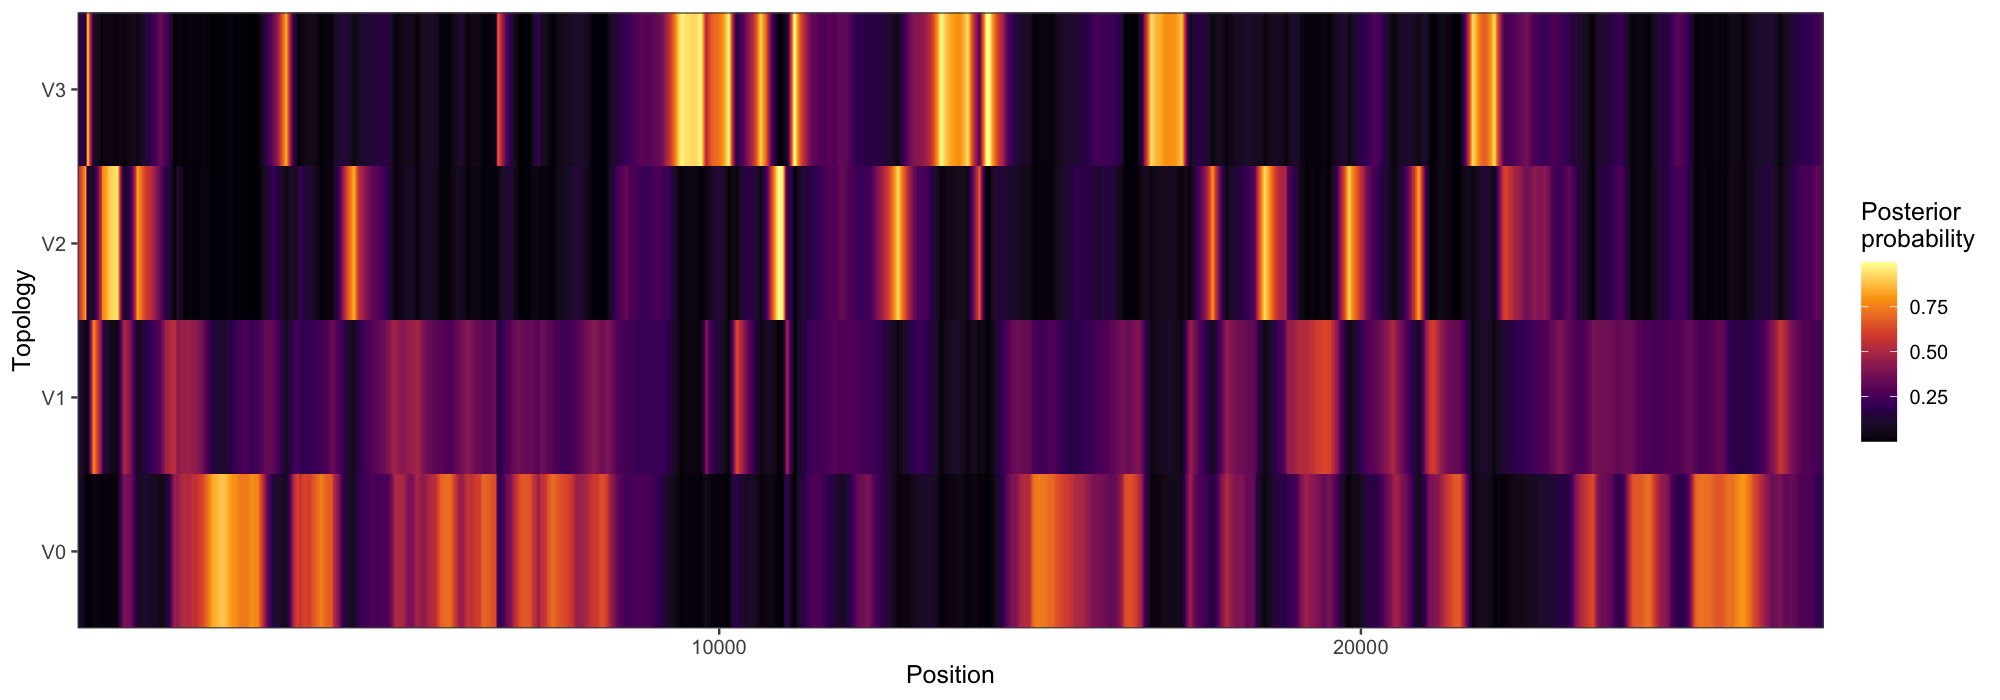

In [269]:
%%R -w 2000 -h 700 -r 150
    
v_post_plt

In [270]:
%%R

ggsave(paste0('v_post_plt_', n_int_AB, '_', n_int_ABC, '.pdf'), 
       v_post_plt, width = 12, height = 4)

In [271]:
%%R 

t1_post_plt <- y_tab %>% 
    group_by(pos, is_V0, t1) %>% 
    summarize(value = sum(value)) %>% 
    ggplot() +
    geom_tile(aes(pos, t1+(!is_V0)*(n_int_AB), fill = value, color = value),
             color = NA) +
    geom_hline(aes(yintercept = n_int_AB-1+0.5), color = 'white') +
    theme_few() +
    scale_fill_viridis_c(name = 'Posterior\nprobability', 
                         # limits = c(0, 1)
                         option="inferno"
                        ) +
    scale_color_viridis_c(name = 'Posterior\nprobability', 
                         # limits = c(0, 1)
                          option="inferno"
                         ) +
    ylab('Interval of first coalescent') +
    xlab('Position') +
    scale_y_continuous(
        breaks = c(0:(n_int_AB-1), ((n_int_AB):(n_int_AB+n_int_ABC-1))+0.1), 
        labels = c(0:(n_int_AB-1), 0:(n_int_ABC-1)),
        expand = c(0, 0)
    ) +
    scale_x_continuous(expand = c(0, 0))

`summarise()` has grouped output by 'pos', 'is_V0'. You can override using the `.groups` argument.


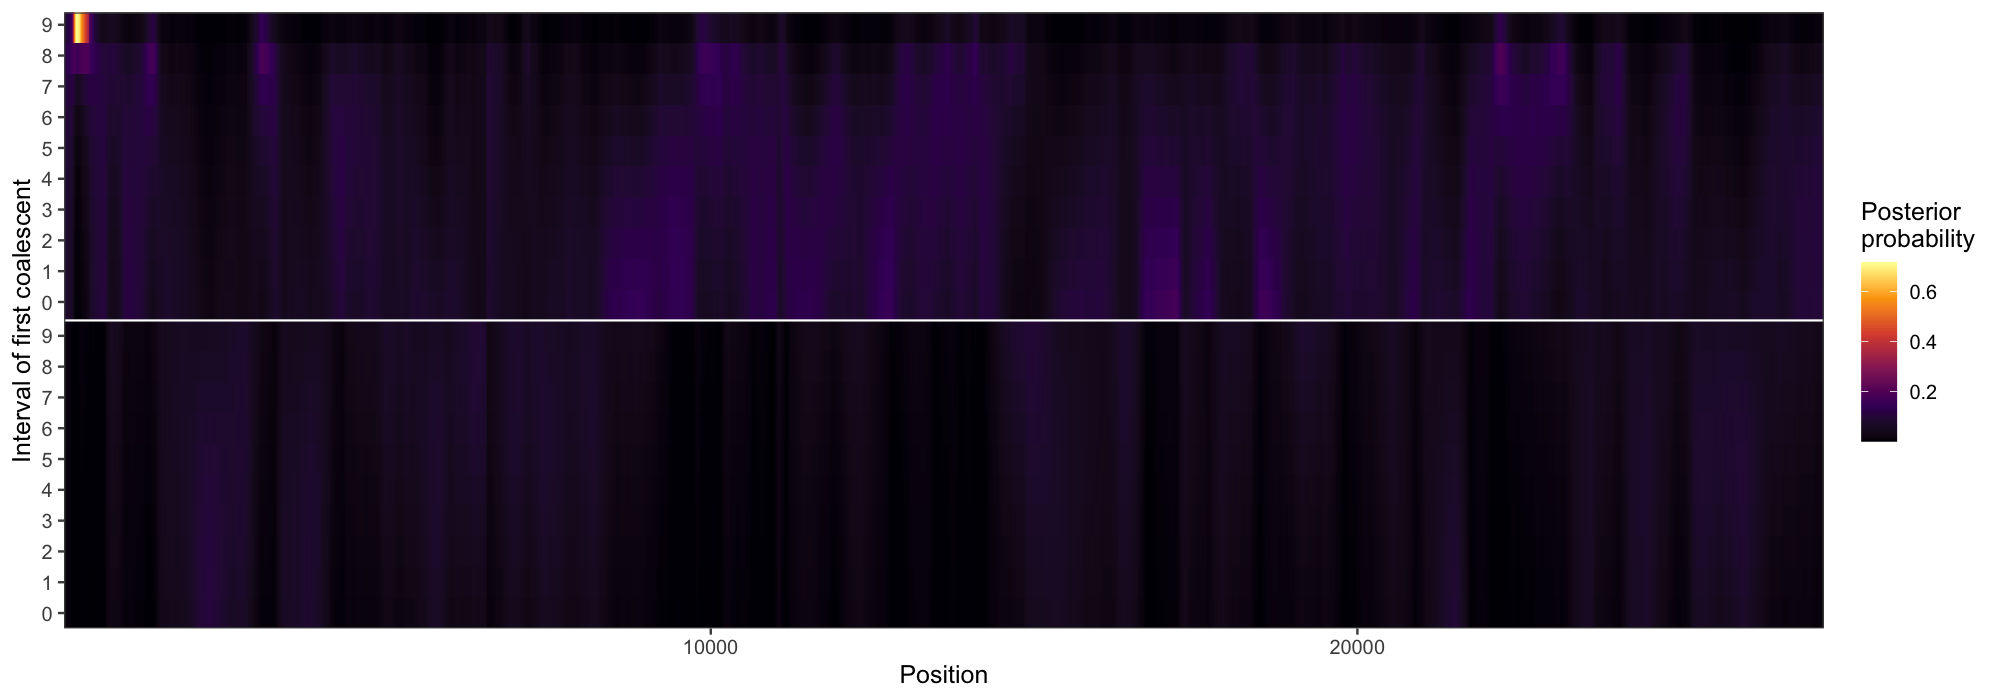

In [272]:
%%R -w 2000 -h 700 -r 150

t1_post_plt

In [273]:
%%R

ggsave(paste0('t1_post_plt_', n_int_AB, '_', n_int_ABC, '.pdf'), 
       t1_post_plt, width = 12, height = 4)

In [274]:
%%R

t2_post_plt <- y_tab %>% 
    # filter(between(pos, lo, up)) %>%
    group_by(pos, t2) %>% 
    summarize(value = sum(value)) %>% 
    ggplot() +
    geom_tile(aes(pos, t2, fill = value, color = value),
             color = NA) +
    theme_few() +
    scale_fill_viridis_c(name = 'Posterior\nprobability', 
                         # limits = c(0, 1)
                         option="inferno"
                        ) +
    scale_color_viridis_c(name = 'Posterior\nprobability', 
                         # limits = c(0, 1)
                          option="inferno"
                         ) +
    ylab('Interval of second coalescent') +
    xlab('Position') +
    scale_y_continuous(
        breaks = 0:(n_int_ABC-1), 
        labels = 0:(n_int_ABC-1),
        expand = c(0, 0)
    ) +
    scale_x_continuous(expand = c(0, 0))

`summarise()` has grouped output by 'pos'. You can override using the `.groups` argument.


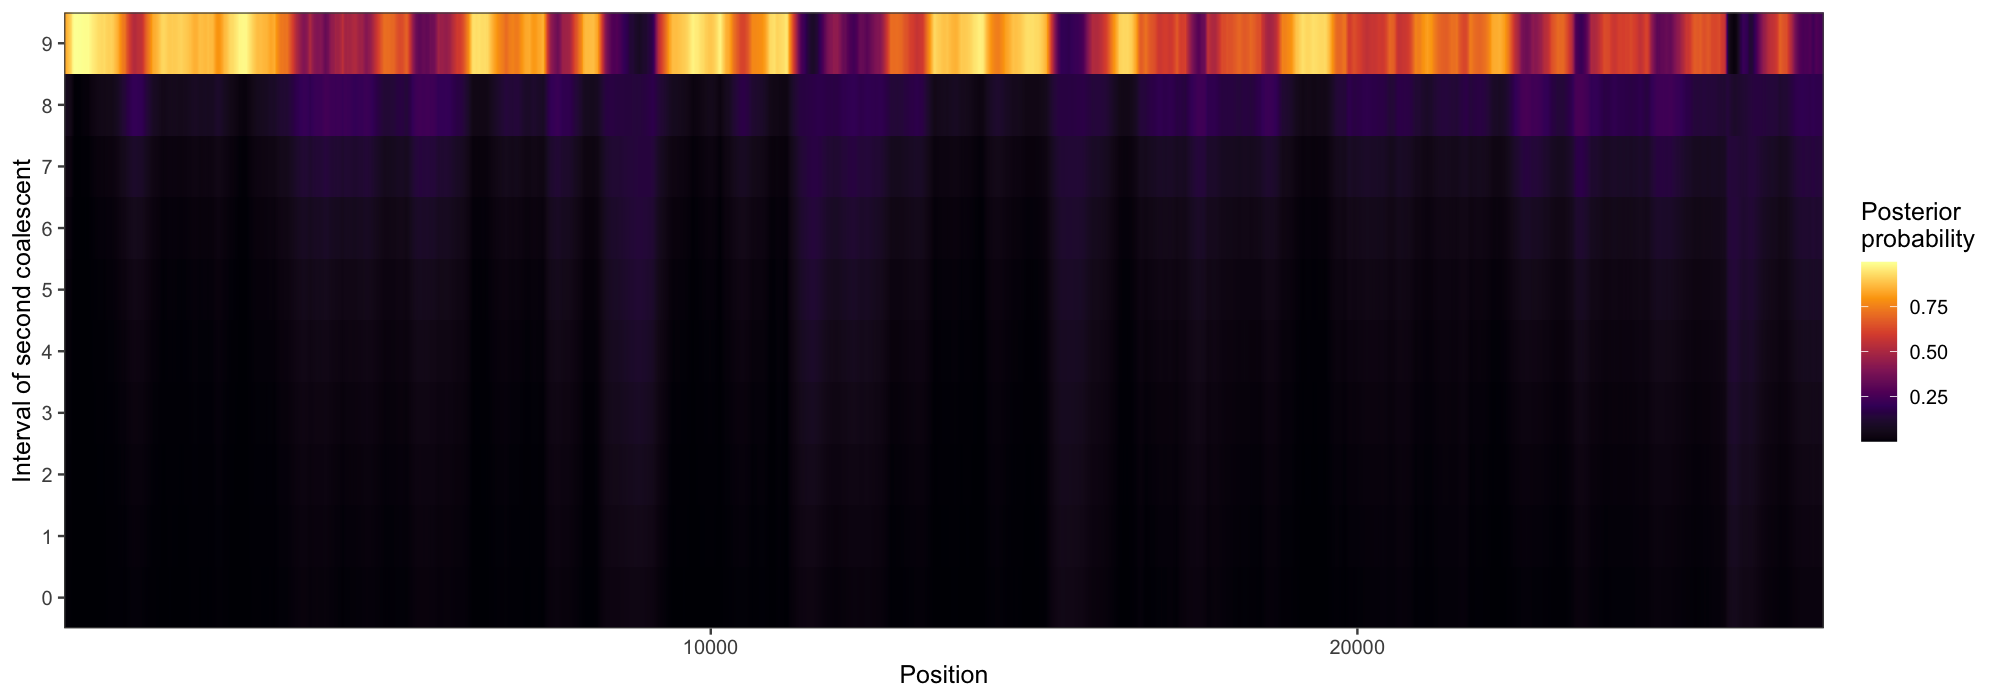

In [275]:
%%R -w 2000 -h 700 -r 150

t2_post_plt

In [276]:
%%R

ggsave(paste0('t2_post_plt_', n_int_AB, '_', n_int_ABC, '.pdf'), 
       t2_post_plt, width = 12, height = 4)

In [277]:
%%R

y_tab %>%
    group_by(pos) %>%
    filter(value == max(value)) %>%
    group_by(V) %>%
    summarize(
        n = n(),
        med = median(value),
        mea = mean(value)
    ) %>%
    ungroup() %>%
    mutate(
        ILS = (n[V==2]+n[V==3])/sum(n)
    )

# A tibble: 4 × 5
      V     n    med    mea   ILS
  <int> <int>  <dbl>  <dbl> <dbl>
1     0  6629 0.0475 0.0483 0.425
2     1  9006 0.0399 0.0470 0.425
3     2  5332 0.0449 0.0507 0.425
4     3  6245 0.0671 0.0678 0.425


In [278]:
%%R

y_tab %>%
    group_by(pos) %>%
    filter(value == max(value)) %>%
    group_by(t2) %>%
    summarize(
        n = n(),
        med = median(value),
        mea = mean(value)
    )

# A tibble: 5 × 4
     t2     n     med     mea
  <int> <int>   <dbl>   <dbl>
1     5    64 0.0117  0.0117 
2     6   148 0.0114  0.0110 
3     7   448 0.00795 0.00810
4     8   319 0.0104  0.0106 
5     9 26233 0.0477  0.0544 


In [279]:
%%R

y_tab %>%
    group_by(pos) %>%
    filter(value == max(value)) %>%
    group_by(is_V0, t1) %>%
    summarize(
        n = n(),
        med = median(value),
        mea = mean(value)
    )

`summarise()` has grouped output by 'is_V0'. You can override using the `.groups` argument.
# A tibble: 19 × 5
# Groups:   is_V0 [2]
   is_V0    t1     n    med    mea
   <lgl> <int> <int>  <dbl>  <dbl>
 1 FALSE     0  5507 0.0440 0.0465
 2 FALSE     1   942 0.0434 0.0581
 3 FALSE     2   817 0.0319 0.0463
 4 FALSE     3   540 0.0393 0.0437
 5 FALSE     4   855 0.0458 0.0442
 6 FALSE     5  2090 0.0386 0.0439
 7 FALSE     6  2173 0.0514 0.0554
 8 FALSE     7  1926 0.0424 0.0514
 9 FALSE     8  5474 0.0478 0.0549
10 FALSE     9   259 0.373  0.366 
11 TRUE      1   224 0.0868 0.0867
12 TRUE      2   403 0.0375 0.0450
13 TRUE      3   319 0.0426 0.0477
14 TRUE      4   156 0.0576 0.0463
15 TRUE      5   623 0.0548 0.0453
16 TRUE      6   878 0.0373 0.0334
17 TRUE      7   787 0.0356 0.0369
18 TRUE      8   504 0.0601 0.0540
19 TRUE      9  2735 0.0559 0.0536
